Import necessary libraries

In [19]:
# imports
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import pandas as pd
import random




In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
data_path = '/content/drive/MyDrive/ai2/data/synthetic_control.data'
data = pd.read_csv(data_path, delim_whitespace=True, header=None)
print(data.head())
print(f"Shape of the dataset: {data.shape}")

        0        1        2        3        4        5        6        7   \
0  28.7812  34.4632  31.3381  31.2834  28.9207  33.7596  25.3969  27.7849   
1  24.8923  25.7410  27.5532  32.8217  27.8789  31.5926  31.4861  35.5469   
2  31.3987  30.6316  26.3983  24.2905  27.8613  28.5491  24.9717  32.4358   
3  25.7740  30.5262  35.4209  25.6033  27.9700  25.2702  28.1320  29.4268   
4  27.1798  29.2498  33.6928  25.6264  24.6555  28.9446  35.7980  34.9446   

        8        9   ...       50       51       52       53       54  \
0  35.2479  27.1159  ...  31.4333  24.5556  33.7431  25.0466  34.9318   
1  27.9516  31.6595  ...  32.5577  31.0205  26.6418  28.4331  33.6564   
2  25.2239  27.3068  ...  33.6318  26.5966  25.5387  32.5434  25.5772   
3  31.4549  27.3200  ...  34.6292  28.7261  28.2979  31.5787  34.6156   
4  24.5596  34.2366  ...  27.7218  27.9601  35.7198  27.5760  35.3375   

        55       56       57       58       59  
0  34.9879  32.4721  33.3759  25.4652  25.8717  


<ipython-input-84-43ce7d51eccf>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(data_path, delim_whitespace=True, header=None)


In [58]:
import numpy as np
import random

def prep_data():
  X = data.values.tolist()
  y = np.array(np.repeat(np.arange(6), 100))

  X_and_y = list(zip(X, y))
  random.seed(42)
  random.shuffle(X_and_y)

  X, y = zip(*X_and_y)

  X = np.array(X)
  y = np.array(y)

  assert X_and_y != sorted(X_and_y, key=lambda x: x[1]), "mix (maybe) not ok, double check"

  return X, y


Training model: Basic_CNN
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Basic_CNN - Test Accuracy: 0.9792
Training model: Deeper_CNN
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Deeper_CNN - Test Accuracy: 0.9833
Training model: CNN_with_Dropout
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
CNN_with_Dropout - Test Accuracy: 0.9833
Training model: CNN_with_GlobalAvgPool
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
CNN_with_GlobalAvgPool - Test Accuracy: 0.9542
Training model: Hybrid_CNN_LSTM
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Hybrid_CNN_LSTM - Test Accuracy: 0.9833

Test accuracy overview:
Basic_CNN: 0.9792
Deeper_CNN: 0.9833
CNN_with_Dropout: 0.9833
CNN_with_GlobalAvgPool: 0.9542
Hybrid_CNN_LSTM: 0.9833


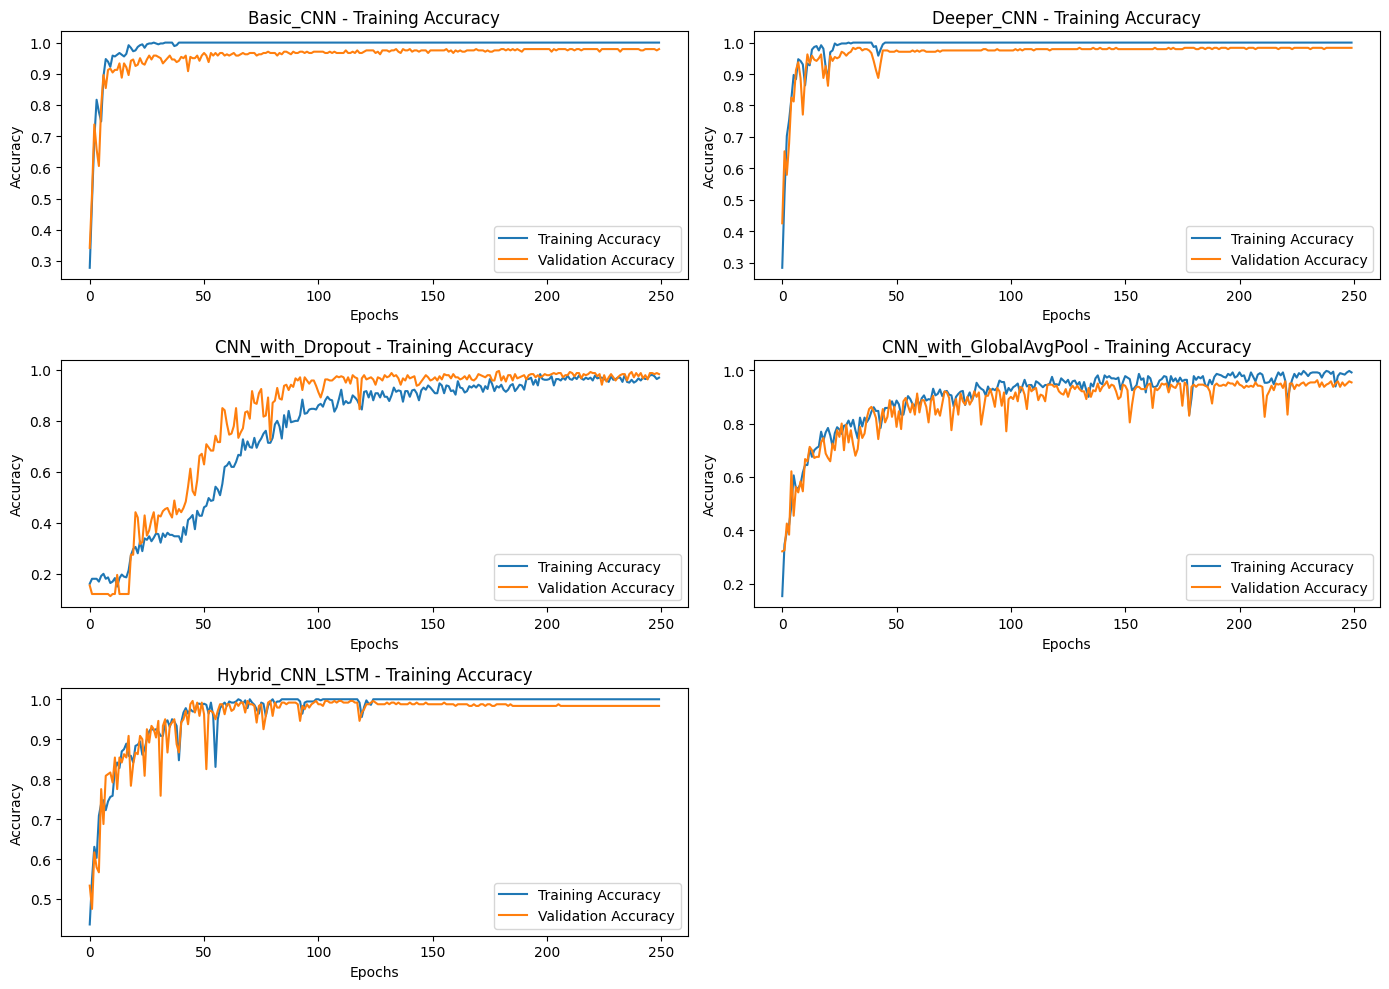

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# List of model architectures
models = []

# Model 0: Basic convolutional network
models.append(("Basic_CNN", Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(n_classes, activation='softmax')
])))


# Model 1: Basic deeper convolutional network
models.append(("Deeper_CNN", Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(n_classes, activation='softmax')
])))

# Model 2: CNN with Dropout layers
models.append(("CNN_with_Dropout", Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])))

# Model 3: CNN with Global Average Pooling
models.append(("CNN_with_GlobalAvgPool", Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalAveragePooling1D(),
    Dense(50, activation='relu'),
    Dense(n_classes, activation='softmax')
])))

# Model 4: Hybrid CNN-LSTM
models.append(("Hybrid_CNN_LSTM", Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False),
    Dense(n_classes, activation='softmax')
])))

# Collecting training history and results for each model
histories = []
accuracies = []
misclassified_samples = {}

# Training and evaluating each model
for name, model in models:
    print(f"Training model: {name}")
    X, y = prep_data()
    # Splitting data into training and test sets
    X = np.array(X).reshape((len(X), time_steps, 1))  # Adding channel dimension
    y = to_categorical(np.array(y))  # Converting target values to categories
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model without printing training losses
    history = model.fit(X_train, y_train, epochs=250, batch_size=16, validation_data=(X_test, y_test), verbose=0)
    histories.append((name, history))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies.append((name, accuracy))
    # Track misclassified samples
    # Predictions and misclassification tracking
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    misclassified = [(i, y_pred_classes[i], y_true_classes[i]) for i in range(len(y_test)) if y_pred_classes[i] != y_true_classes[i]]
    misclassified_samples[name] = misclassified

    print(f"{name} - Test Accuracy: {accuracy:.4f}")

# Displaying test accuracies for all models
print("\nTest accuracy overview:")
for name, accuracy in accuracies:
    print(f"{name}: {accuracy:.4f}")

# Plotting training progress
plt.figure(figsize=(14, 10))
for i, (name, history) in enumerate(histories):
    plt.subplot(3, 2, i+1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{name} - Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

plt.tight_layout()
plt.show()


In [82]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score


# Prepare test data
X, y = prep_data()
X = np.array(X).reshape((len(X), time_steps, 1))  # Adding channel dimension
y = to_categorical(np.array(y))  # Converting target values to categories
_, X_test, _, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


# Predict classes with each model and collect predictions
model_predictions = []

for name, model in models:
    # Predict on the test set and store predictions
    y_pred = model.predict(X_test)
    model_predictions.append(np.argmax(y_pred, axis=1))

model_predictions = np.array(model_predictions)

# Perform majority voting along the first axis (models)
ensemble_predictions, _ = mode(model_predictions, axis=0)
ensemble_predictions = ensemble_predictions.flatten()  # Flatten the array to match shape

# Calculate ensemble accuracy
ensemble_accuracy = accuracy_score(y_true_classes, ensemble_predictions)
print(f"Ensemble Model - Test Accuracy: {ensemble_accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Ensemble Model - Test Accuracy: 0.9875


In [85]:
# Find misclassified samples
misclassified_samples = [(index, pred, true)
                         for index, (pred, true) in enumerate(zip(ensemble_predictions, y_true_classes))
                         if pred != true]

# Print misclassified samples
print("\nMisclassified Samples:")
print("Index | Predicted | True")
for index, pred, true in misclassified_samples:
    print(f"{index:<6} | {pred:<9} | {true}")


Misclassified Samples:
Index | Predicted | True
48     | 5         | 3
174    | 2         | 4
228    | 5         | 3


In [87]:
_, X_test, _, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

ensemble_miss_samples = X_test[48], X_test[174], X_test[228]

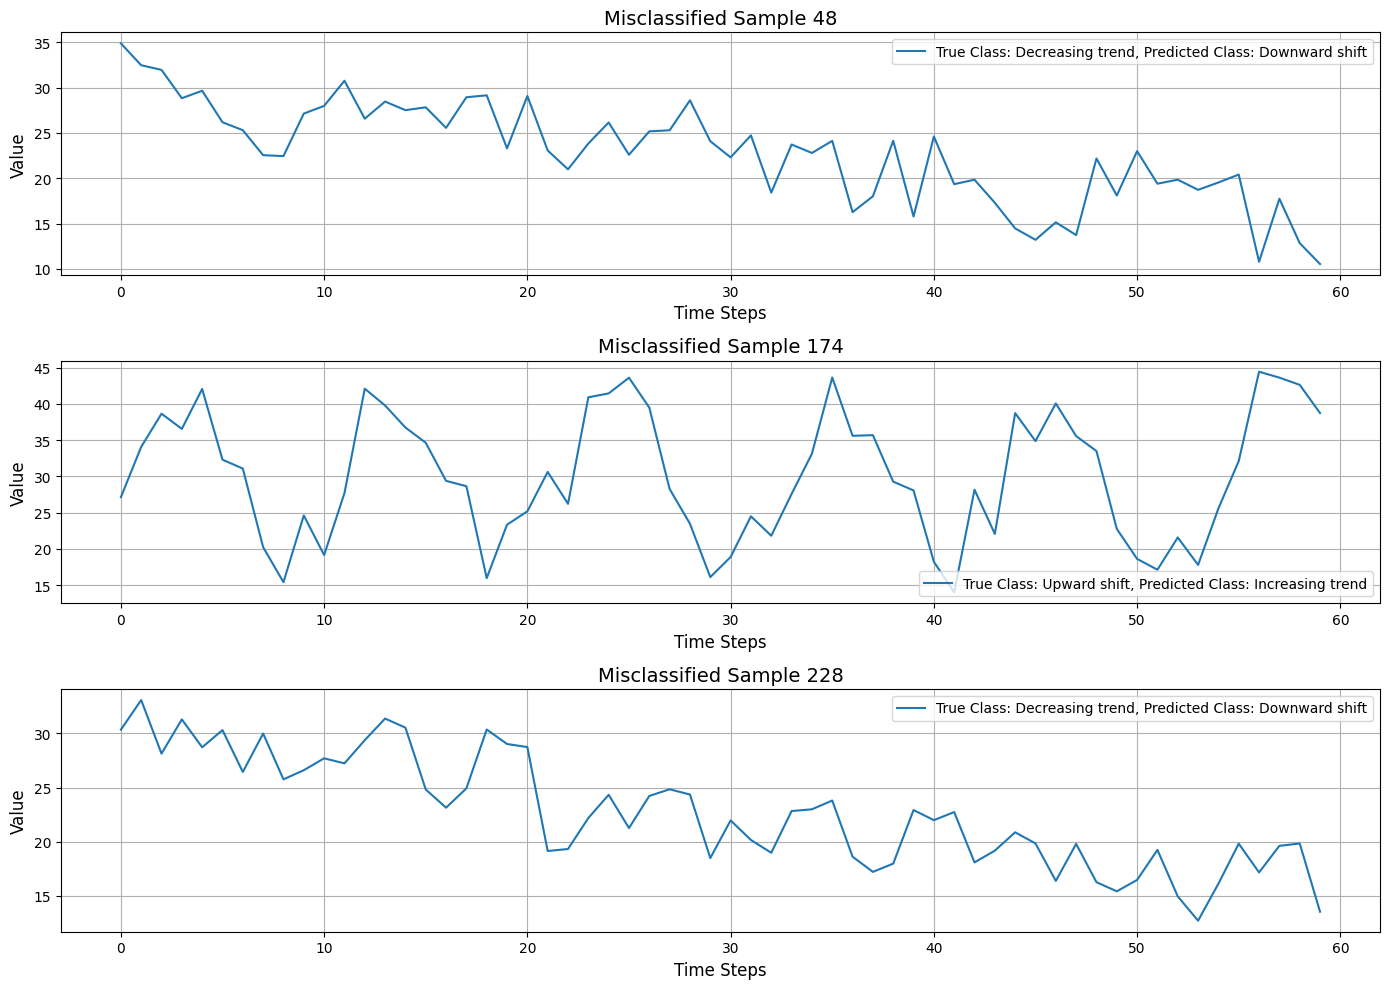

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the misclassified samples and their indices are already defined
ensemble_miss_samples = [X_test[i].flatten() for i in ensemble_miss_indices]  # Flatten to 1D for plotting
true_classes = ["Decreasing trend", "Upward shift", "Decreasing trend"]
predicted_classes = ["Downward shift", "Increasing trend", "Downward shift"]
ensemble_miss_indices = [48, 174, 228]

# Create a larger figure for the misclassified samples
plt.figure(figsize=(14, 10))  # Adjust size as needed

# Plot each misclassified sample
for i, sample in enumerate(ensemble_miss_samples):
    plt.subplot(len(ensemble_miss_samples), 1, i + 1)
    plt.plot(sample, label=f'True Class: {true_classes[i]}, Predicted Class: {predicted_classes[i]}')
    plt.title(f'Misclassified Sample {ensemble_miss_indices[i]}', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
